# 1. 초기화
import lots of modules and set up filters regarding raw data

In [ ]:
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

from matplotlib import font_manager, rc

# ## matplotlib에 대해서 한글 깨짐 방지 - OSX
# # rc('font', family='AppleGothic')
# # matplotlib.rcParams['axes.unicode_minus'] = False   

# ## matplotlib에 대해서 한글 깨짐 방지 - Windows
# matplotlib.rcParams['axes.unicode_minus'] = False

import platform
# Window 
if platform.system() == 'Windows': 
    matplotlib.rc('font', family='Malgun Gothic')
elif platform.system() == 'Darwin': 
    # Mac 
    matplotlib.rc('font', family='AppleGothic')
else: 
    #linux 
    matplotlib.rc('font', family='NanumGothic') 

# 그래프에 마이너스 표시가 되도록 변경 
matplotlib.rcParams['axes.unicode_minus'] = False



In [ ]:
column_filter = ['배송자휴대전화번호', 'T기프트배송자휴대전화번호', '주문번호', '주문일', '취소일', '결제일', '개통일', '배송일', '모델명', '가입유형', '약정프로그램', '요금제', '무약정Plan선택여부', 
                        '결제방법', '배송방법', '대리점', '주문유형', '쿠폰여부', '지인(추천인)코드', '개통일자', '센터명', '모바일구매여부', '상품구분(맞춤/패키지)', 
                        '서비스관리번호', 'TG상태값', '주문구분', '상담사소속', '대리점코드(중분류)', '외부유입경로', '약정구분', '포인트결제', '동의방법', 
                        '뉴보상기변 쓰던폰반납여부', '오늘보상 신청여부', '오늘보상 수거상태', '클럽기변 신청서 상태', 'T 갤럭시 클럽', '클럽기변 단말기할부금 면제금액', 
                        '대리점명', '매장명', 'D코드', '발송일']

# 개별 데이터를 상반부와 하반부를 합쳐서 생성

In [ ]:
# 기준이 되는 24일 ars 인입 고객 정보 로딩 - 나이 연령 정보 포함됨
customer_24 = pd.DataFrame(pd.read_csv('./access_nums_age_sex.csv'),columns=['전화번호', '나이', '성별'])
customer_24['나이'] = pd.to_numeric (customer_24['나이'], errors = 'coerce')
customer_24_drop_na = customer_24.dropna (axis=0)
index_names = customer_24_drop_na[ customer_24_drop_na['성별'] == '#' ].index

customer_24_drop_na.drop(index_names, inplace=True)
display(customer_24_drop_na)

## 8월 24일 상담센터 인입고객 성별 비율 계산 및 시각화

In [ ]:
## 24일 인입된 데이터에 대해서 성별로 정리해서 개수를 세도록 한다.
pivot_sex = pd.pivot_table(customer_24_drop_na, index="성별", values=['전화번호'], aggfunc='count')
display(pivot_sex)


In [ ]:
pivot_sex.plot.pie(y="전화번호", autopct='%1.1f%%')

### 위 차트 상으로 남자가 비중이 높다고 볼 수 있지만, 이 내용만으로 유의미한 결론이 나오지 않는다. 오히려, 성별과 나이대를 계산 hitmap을 그리도록 하자

In [ ]:
## 히트맵 계산을 위해서, 나이대를 10 살 단위 기준으로 데이터를 정형화 하도록 한다.
## 이를 위해서 기존 데이터에 신규 칼럼 - "연령대" 을 추가하도록 하자.

age_band_width = 10
customer_24_drop_na['나이대'] = customer_24_drop_na['나이'].apply (lambda x: int(x/age_band_width) * age_band_width)
#customer_24_drop_na.head()

pivot_sex_age = pd.pivot_table(customer_24_drop_na, index="성별", columns = ["나이대"], values=['전화번호'], aggfunc='count')
display(pivot_sex_age)

In [ ]:
fig = plt.figure(figsize=(20,5))
fig.set_facecolor('white')
 
sns.heatmap(pivot_sex_age, cmap='Blues', annot=True, fmt=".0f")
plt.show()

## 28일 하루 기준으로 상담센터에 전화를 한 고객의 나이 및 성별에 대해서는 다음과 같이 정리 가능
* 상대적으로 여자 보다 남자가 좀 더 전화를 통해서 예판 참여 후 상담센터에 전화를 걸었다.
* 분포 자체는 남성/여성 모두에 있어서 30대가 가장 높은 비중으로 전화로 연결을 많이 했다.

위와 같은 상담센터 이용에 있어서 성별, 나이별 차이는 현재 대상 데이터가 예판 대상 장비와 연관이 있어서, 일반적이지는 않다라고 판단이 가능.

# 실제 위 분포의 특이성을 확인하기 위해선, **전체 갤럭시 폴더블 예판 참가자 분포와 차이가 있는지 분석이 필요**

# 예판 시점에 상담센터에 전화를 한 고객 특성을 분석하자. 우리는 상담센터에 전화를 건 사람들이 가지고 있는 특성이 궁금하다. 
* 예를 들어서 어떤 특정 요금제를 사용하는 사람들인지 아니면 어떤 개통 상 특이 사항이 있는 고객들인지?
* 특정 가입 채널 분포가 더 높은지 이것도 아니면, 가입 단말이 특이 하던지?
* 이러한 관점들에 대해서 실제 데이터를 기준으로 검증을 해나가고자 한다.

# 관련 데이터 준비 단계 - 원 주문 데이터와 접근자 핸폰 정보를 하나로 구성

## 고객별 주문 데이터를 준비 - orders

In [ ]:
# 모바일 주문 정보 로딩 
mobile_order_1 = pd.DataFrame (pd.read_csv('./1_m.csv', dtype={'배송자휴대전화번호':str, 'T기프트배송자휴대전화번호':str}), columns=column_filter)
mobile_order_2 = pd.DataFrame (pd.read_csv('./2_m.csv', dtype={'배송자휴대전화번호':str, 'T기프트배송자휴대전화번호':str}), columns=column_filter)
mobile_orders = pd.concat([mobile_order_1, mobile_order_2], ignore_index=True, axis=0)
mobile_orders.reset_index(drop=True)

In [ ]:
# 바로픽업 정보들 로딩
pickup_order_1 = pd.DataFrame (pd.read_csv('./1_b.csv', dtype={'배송자휴대전화번호':str, 'T기프트배송자휴대전화번호':str}), columns=column_filter)
pickup_order_2 = pd.DataFrame (pd.read_csv('./2_b.csv', dtype={'배송자휴대전화번호':str, 'T기프트배송자휴대전화번호':str}), columns=column_filter)
pickup_orders = pd.concat([pickup_order_1, pickup_order_2], ignore_index=True, axis=0)
pickup_orders.reset_index(drop=True)

In [ ]:
# build up a merged dataframe that includes all data (mobile and pickup)
# 하나로 값들을 통합하는 동시에, 전화번호 중 유효한 번호로 데이터를 조합 새로운 칼럼을 만들었다.


orders = pd.concat([mobile_orders, pickup_orders], ignore_index=True, axis=0)

def merge_phone_num (row) :
    if row['배송자휴대전화번호'] != 'NaN' and isinstance(row['배송자휴대전화번호'], str) == True:
        return str(row['배송자휴대전화번호'])
    else:
        # if np.isnan(row['배송자휴대전화번호']) :
        #     print (">>" + str(type(row['배송자휴대전화번호'])) + " -- "+str(row['배송자휴대전화번호'] + " ;;; "+str(row['T기프트배송자휴대전화번호'])))
        # print ("target: "+row['배송자휴대전화번호']+" ---> "+row['T기프트배송자휴대전화번호'])
        return str(row['T기프트배송자휴대전화번호'])


orders['PhoneNum'] = orders.apply(lambda row: merge_phone_num(row), axis=1)

orders


## 고객 센터 인입 고객 데이터 준비 - accesslog

In [ ]:
# raw data를  읽어들임임
accesslog = pd.DataFrame (pd.read_csv('./access_raw.csv'))
index_names = accesslog[ accesslog['PhoneNum'] == '*' ].index

accesslog.drop(index_names, inplace=True)
display (accesslog)

In [ ]:
# pivot으로 ID(전화번호) 별 전화 회수 테이블 구성
pivot_call_history = pd.pivot_table(accesslog, index="PhoneNum", values=['인입일자'], aggfunc='count')
pivot_call_history.columns.to_list()

reshaped_call_history = pivot_call_history.copy()
reshaped_call_history.columns = reshaped_call_history.columns.values
reshaped_call_history.reset_index (level=0, inplace=True)

reshaped_call_history


In [ ]:
accesslog_connected = accesslog[accesslog['상담사연결'] == 'O']
#display(accesslog_connected)

pivot_connected_count = pd.pivot_table(accesslog_connected, values="상담사연결", index="PhoneNum", aggfunc="count")
display(pivot_connected_count)

In [ ]:
# 상담사연결 회수까지 반영해서 기존 reshaped_call_history를 보강한다.

reshaped_call_history = pd.merge (reshaped_call_history, pivot_connected_count, how="left", on="PhoneNum")
reshaped_call_history = reshaped_call_history.fillna(0)

def cal_connect_rate(row) :
    return row['상담사연결']/row['인입일자']
reshaped_call_history['연결율'] = reshaped_call_history.apply(lambda row: cal_connect_rate(row), axis = 1)
display(reshaped_call_history)




## 개인별 연결율에 따른 만족도 
### 1.0 은 1번 전화해서 1번 연결
### 0.5 는 2번 전화해서 1번 연결

In [ ]:
reshaped_call_history['연결율'].hist(bins=100)

## 상담사 연결이 된 회수에 따른 고객 분포
### 상담사 연결이 3이라면, 고객이 상담사와 최종 연결을 3번이 이루어진 고객을 지칭

In [ ]:
#상담사 연결 회수에 따른 분포
reshaped_call_history_2 = reshaped_call_history.copy()
dist_connected_pivot = pd.pivot_table(reshaped_call_history_2, index='상담사연결', values='PhoneNum', aggfunc='count')
#display(dist_connected_pivot)
dist_connected_pivot.plot()

## 시도를 했지만, 연결이 안 된 고객들 전화 시도 분포

In [ ]:
not_connected_users = reshaped_call_history[reshaped_call_history['상담사연결'] == 0]

pivot_not_connect_dist = pd.pivot_table(not_connected_users, index="상담사연결", columns="인입일자", values="PhoneNum", aggfunc="count")
display (pivot_not_connect_dist)

In [ ]:
# 전화건 고객과 주문 내역을 묶어서 caller_and_order DataFrame을 구성하자.
caller_and_order = pd.merge(reshaped_call_history, orders, how="left", on="PhoneNum")
display(caller_and_order)


In [ ]:
# 병합한 데이터 청소를 해야 한다. 주문번호가 없는 친구들 비중이 어떻게 되지?

cleaned_caller_and_order = caller_and_order[caller_and_order['주문번호'].notna()]
cleaned_caller_and_order.reindex()


In [ ]:
print ("전체 인입된 전화 번호 개수: "+ str(caller_and_order.size))
print ("실제 주문 번호와 매칭된 전화 개수:"+str(cleaned_caller_and_order.size))
ratio_of_no_order_id = cleaned_caller_and_order.size / caller_and_order.size
print (">> 주문 번호가 없는 전화 비중: "+ str((1 - ratio_of_no_order_id)*100))

In [ ]:
주문번호별_전화번호_개수 = pd.pivot_table (cleaned_caller_and_order, index="PhoneNum", values=['주문번호'], aggfunc='count', margins=True)
#display(주문번호별_전화번호_개수)

pivot_order_count_per_phoneNum = 주문번호별_전화번호_개수.copy()
pivot_order_count_per_phoneNum.columns = 주문번호별_전화번호_개수.columns.values
pivot_order_count_per_phoneNum.reset_index (level=0, inplace=True)
display(pivot_order_count_per_phoneNum)


pivot_hist_df = pd.pivot_table (pivot_order_count_per_phoneNum, index="주문번호", values=['PhoneNum'], aggfunc='count', margins=True)
display(pivot_hist_df)


In [ ]:
# cleaned_caller_and_order.to_csv("../cleaned.csv", encoding = 'utf-8' )

## 전체 인입된 ARS 번호에 대해서 주문번호와 직접 매칭되지 않은 주문 번호들 값이 전체 인입 전화 중 약 32%를 차지한다.

### !!!! 아직 남은 의문.. 약 32%에 해당하는 주문과 연결되지 않은 전화 번호들은 어떤 것들일까??? 이 부분에 대해서 확인이 필요하다.

In [ ]:
## 분석 전 기존 데이터에 대한 추가 가공

# 예판 모델을 구매한 주문인지 여부를 신규 칼럽으로 추가
def add_yn_column_for_folderble(row):
    modelcode = str(row['모델명'])
    if modelcode.startswith('SM-F711') or modelcode.startswith('SM-F926'):
        return "Y"
    else:
        return "N"

cleaned_caller_and_order['예판모델'] = cleaned_caller_and_order.apply(lambda row: add_yn_column_for_folderble(row), axis=1)

# 분석  수행을 하도록 한다.
---- 
## 분석 1. 24일 기준 인입된 고객들 성별/연령 특이 사항이 있는가?
----

### 본 항목에 대해서는 앞선 데이터 분석 결과 참고
### 현재 성별이나 연령에 있어서 특이 사항이 보이지는 않는다.

----
## 분석 2. 예판 기간 고객센터 전화 건 고객들 가입유형 특성은 어떻게 되는가?
----


In [ ]:
join_pattern_pivot = pd.pivot_table (cleaned_caller_and_order, index=["가입유형"], values=['PhoneNum'], aggfunc=(lambda x: len(x.unique())), margins=True)
display(join_pattern_pivot)

join_pattern_pivot_1 = pd.pivot_table (cleaned_caller_and_order, index=["가입유형","예판모델"], values=['PhoneNum'], aggfunc=(lambda x: len(x.unique())), margins=True)
display(join_pattern_pivot_1)


## 위 데이터를 보게 되면, 절대다수가 기기변경을 진행하는 고객이며, 이 중에서도 예판 참석을 했던 고객들인 것은 자명해 보인다.
## 그런데, 고객 회수 기준으로 반복 전화를 건 고객 특성 확인하기 위해서, 이들에 대한 전화 회수 데이터도 추가한다.

In [ ]:
join_pattern_pivot_2 = pd.pivot_table (cleaned_caller_and_order, index=["가입유형"], values=['인입일자'], aggfunc='sum')
join_pattern_pivot_2_1 = pd.pivot_table (cleaned_caller_and_order, index=["가입유형"], values=['PhoneNum'], aggfunc=(lambda x: len(x.unique())))

#display(join_pattern_pivot_2)

join_pattern_merge = pd.merge(join_pattern_pivot_2_1, join_pattern_pivot_2, how="left", on="가입유형")
join_pattern_ratio = join_pattern_merge.copy()
join_pattern_ratio.columns = join_pattern_merge.columns.values
join_pattern_ratio.reset_index (level=0, inplace=True)

def cal_ratio(row):
    return row['인입일자'] / row['PhoneNum']

join_pattern_ratio["1인당 콜 회수 평균"] = join_pattern_ratio.apply(lambda row: cal_ratio(row), axis=1)
display(join_pattern_ratio)

## 상대적으로 1인당 콜 회수 평균은 번호이동 이나 신규가입 같이 기존 SKT가 아닌 타사 고객인 경우가 많은 것으로 보인다.
### 그런데, 평균 1인당 콜 회수가 6번이 넘어간다니.. 이 자체가 비정상적 아닌가? 물론 연결율이 안 좋았기는 해서 그렇다고 보인다만.
### 그렇다면 연결된 회수 기준으로 고객 연결 회수 분포를 및 평균을 확인해보면 어떨까?

In [ ]:
sns.distplot(reshaped_call_history['인입일자'])
plt.show()

----
## 분석 3. 예판 기간 고객센터 전화 건 고객들 가입채널은 어떻게 되는가?
----

In [ ]:
# 가입 채널별로 인입되었던 고객들 위치를 확인한다.
print ("전체 주문 수 : " + str(cleaned_caller_and_order['주문번호'].unique().size))

channel_order_sum = pd.pivot_table (cleaned_caller_and_order, index="주문구분", values=['주문번호'], aggfunc='count', margins=True)
#display(channel_order_sum)

channel_customer_sum = pd.pivot_table (cleaned_caller_and_order, index="주문구분", values=['PhoneNum'], aggfunc=(lambda x: len(x.unique())), margins=True)
#display(channel_customer_sum)


channel_status = pd.merge(channel_customer_sum, channel_order_sum, how='left', on='주문구분')
channel_status['고객당_주문_개수_비'] = channel_status.apply(lambda row: row['주문번호']/row['PhoneNum'], axis=1)
display(channel_status)




----
## 분석 4. 예판 기간 고객센터 전화 건 고객들 주된 가입 단말은 어떻게 되는가? 
----

In [ ]:
#print(cleaned_caller_and_order.columns.to_list)

In [ ]:
# phone_model_df = cleaned_caller_and_order.copy()

def add_yn_column_for_folderble(row):
    modelcode = str(row['모델명'])
    if modelcode.startswith('SM-F711') or modelcode.startswith('SM-F926'):
        return "Y"
    else:
        return "N"

cleaned_caller_and_order['예판모델'] = cleaned_caller_and_order.apply(lambda row: add_yn_column_for_folderble(row), axis=1)

phone_model_pivot_level_1 = pd.pivot_table (cleaned_caller_and_order, index=["예판모델"], values=['주문번호'], aggfunc='count', margins=True)
display(phone_model_pivot_level_1)

phone_model_pivot_level_3 = pd.pivot_table (cleaned_caller_and_order, index=["예판모델"], values=['PhoneNum'], aggfunc=(lambda x: len(x.unique())), margins=True)

display(phone_model_pivot_level_3)

phone_model_pivot_level_2 = pd.pivot_table (cleaned_caller_and_order, index=["예판모델",'모델명'], values=['주문번호'], aggfunc='count', margins=True)
display(phone_model_pivot_level_2)

print("전체 콜센터 전화건 고객 중 예판 모델 외 건으로 전화한 고객 수 (6165명/17147명): "+ str(6165/17247*100) +"%")


## 위 데이터에 따르면, 예판 모델에 의한 전화 통화 수가 전체 전화 발송 고객 주문번호 기준 36% 고객이 예판 때문에 전화를 한 것이 아니었다.
### !!! 예판 고객과 아닌 고객들의 전화 통화 인입 건수 비중 확인 필요

----
## 분석 5. 예판 기간 고객센터 전화 건 고객들 중 클럽기변 비중은?
----

In [ ]:
club_package_pivot = pd.pivot_table (cleaned_caller_and_order, index=["클럽기변 신청서 상태", '예판모델'], values=['PhoneNum'], aggfunc=(lambda x: len(x.unique())), margins=True)
display(club_package_pivot)

print ("클럽기변 고객 수 비중: "+str(717/14572))

## 위 데이터에 따르면, 콜센터 전화 고객 중 클럽기변 신청자 비중은 약 5% 차지하며, 이 고객에 대한 대응이 전체 연결율을 향상 시키지는 않을 것 같다.
### !!! 반복 전화 고객 중에서 클럽 기변 비중에 대해서 확인이 필요하다.

----
## 분석 6. 예판 기간 고객센터 전화 건 고객들 라이트할부 신청여부 비중은?
----
### 라이트할부에 대해서는 대상 고객을 찾아내는 데이터를 발견하지 못 했습니다. 
### 아애 대해서는 추가적인 데이터 확인을 통해서 확인 가능합니다.

----
## 분석 7. 10회 이상 상담한 고객에 대한 Swing 대화 내역 검토 (관련해서는 상담센터 확인 필요)
----
### 여기서는 우선 10회 아상 상담한 고객에 대한 연락처 정보를 확인하도록 한다.
### 대상 정보는 swing_check_calls.csv로 추출 저장을 합니다.


In [ ]:
over_10_caller_df = cleaned_caller_and_order[cleaned_caller_and_order['인입일자'] >= 10]
# display(over_10_caller_df)

low_connect_ratio_and_high_call_freq = over_10_caller_df[over_10_caller_df['연결율'] < 0.3]
# displa/y(low_connect_ratio_and_high_call_freq)

filter_cols = ['PhoneNum', '인입일자', '상담사연결', '연결율', '주문번호']
extracted_target_caller = low_connect_ratio_and_high_call_freq[['PhoneNum', '인입일자', '상담사연결', '연결율', '주문번호']]

display(extracted_target_caller)
extracted_target_caller.to_csv('./swing_check_calls.csv')

----
## 분석 8. 10회 이상 전화를 한 고객들에 대해서 나이 성별 데이터 확인을 해보자.
### 모수가 작아져서 우선 연결율 제약은 0.5를 두었다가 제거를 해서 우선 접근하자.
----


In [ ]:
# 연결율이 0.5 이하이며, 10회 이상 전화를 건 고객이 가지는 특성을 알아보자.

target_callers_with_high_freq_and_low_connect = over_10_caller_df[over_10_caller_df['연결율'] < 0.5]
# display(target_callers_with_high_freq_and_low_connect)
# display(customer_24_drop_na)

joined_caller_info_for_24 = pd.merge(left=customer_24_drop_na, right=over_10_caller_df, how="inner", left_on="전화번호", right_on="PhoneNum")
display(joined_caller_info_for_24)

In [ ]:
## 10회 이상 전화를 건 고객 성별 정보 특이 사항이나, 나이에 있어서 분포를 그려보자.

joined_caller_info_for_24[['인입일자', '나이']].plot.scatter(x="나이", y="인입일자", alpha=0.1)
joined_caller_info_for_24[['인입일자', '성별']].plot.scatter(x="성별", y="인입일자", alpha=0.1)
joined_caller_info_for_24[['나이', '성별']].plot.scatter(x="성별", y="나이", alpha=0.1)

### 위 결과만을 봐서는 어떤 특정지어지는 성별/나이와 반복 전화 특성이 보이지 않는다.
### 연결율이 낮은 대상군 0.5 이하 대상군을 기준으로 했을 때, 차이를 시각적으로 살펴 보자

In [ ]:
joined_caller_info_with_low_connect_ratio = pd.merge(left=customer_24_drop_na, right=target_callers_with_high_freq_and_low_connect, how="inner", left_on="전화번호", right_on="PhoneNum")

joined_caller_info_with_low_connect_ratio[['인입일자', '나이']].plot.scatter(x="나이", y="인입일자", alpha=0.5)
joined_caller_info_with_low_connect_ratio[['인입일자', '성별']].plot.scatter(x="성별", y="인입일자", alpha=0.5)
joined_caller_info_with_low_connect_ratio[['나이', '성별']].plot.scatter(x="성별", y="나이", alpha=0.5)

## 다른 관점에서 바라봐야 할 부분에 대한 의견이 필요합니다.
## 유의미한 것은 !! 남성 여성 특정 성별이나 나이대에 집중이 되어 있는 것은 아닌지에 대한 편견은 의미가 없다는 판단이 됩니다.

----
## 분석 9. 자동/셀프 개통 진행여부
----

In [ ]:
# 대상 고객을 5회 이상 전화를 한 고객으로 한정해서 데이터를 분석하자.
# 이를 위해서 기존 정리된 데이터에서 5회 이상 연락자 정보를 추출한다.

over_5_caller_df = cleaned_caller_and_order[cleaned_caller_and_order['인입일자'] >= 5]
display(over_5_caller_df.columns.to_list)

In [ ]:
# 5회 이상 전화건 고객에 대한 동의 방법에 따른 분포
pd.pivot_table(over_5_caller_df, index='동의방법', values='PhoneNum', columns='주문구분', aggfunc='count', margins=True)


In [ ]:
pd.pivot_table(over_10_caller_df, index='동의방법', values='PhoneNum', columns='주문구분', aggfunc='count', margins=True)


## 5회 이상, 10회 이상 전화를 한 고객들 대상을 보면, MMS동의 및 녹취동의를 한 고객이 높은 비중으로 상담센터에 다수 전화를 하고 있다.
## 그런 측면으로 보아야 할지 모르겠지만, 인입 채널이 온라인이 아닌 고객센터 통한 개통이 훨씬 많은 비중으로 전화를 다수 진행

## 가입 채널을 통한 배포를 다시 전화를 한 고객 대상으로 분석해보자.

In [ ]:
pd.pivot_table(over_5_caller_df, index='주문구분', values='PhoneNum', aggfunc='count', margins=True)


In [ ]:
pd.pivot_table(over_10_caller_df, index='주문구분', values='PhoneNum', aggfunc='count', margins=True)


## 위 데이터 점검을 하니, '동의방법'이 기록되지 않은 고객이 혼란을 주어, 오히려 잘못된 결론으로 유도가 되었다.
## 상담센터에 전화를 자주 건 고객은 특별이 센터나, TDS 웹이냐 따라서 영향을 받지는 않았다.

----
## 분석 10. 배송유형 
----

In [ ]:
pd.pivot_table(over_5_caller_df, index='배송방법', values='인입일자', aggfunc='mean', margins=True)


In [ ]:
pd.pivot_table(over_5_caller_df, index='배송방법', values='PhoneNum', aggfunc='count', margins=True)


## 배송 방법에 따른 전화 회수 또는 전화를 자주하는 특정 배송 방법은 발견되지 않았습니다.

----
## 분석 11. 바로보상 신청여부
----

In [ ]:
pd.pivot_table(over_5_caller_df, index='오늘보상 신청여부', values='PhoneNum', aggfunc='count', margins=True)


In [ ]:
pd.pivot_table(over_10_caller_df, index='오늘보상 신청여부', values='PhoneNum', aggfunc='count', margins=True)


## 위 데이터를 기준으로 보았을 때, 오늘보상 신청한 고객 경우에 관련해서 전화를 자주했음을 확인할 수 있습니다.
## 추가로 오늘보상 신청한 고객들에 대해서 전화 회수도 유의미하게 높은지 알아봅니다.

In [ ]:
pd.pivot_table(over_10_caller_df, index='오늘보상 신청여부', values='인입일자', aggfunc='mean', margins=True)


## 오늘보상을 신청했다고 해서, 평균 수치가 높은 것은 아니라는 생각도 들지만,
## 이는 바른 해석일까 다시 한 번 고민해볼 필요가 있다.

----
## 분석 12. 주문- 배송- 개통 일자 leadtime 분석
----

In [ ]:
over_5_caller_df.columns.to_list

In [86]:
leadtime_df = over_10_caller_df[['PhoneNum', '결제일', '발송일', '배송일', '개통일', '연결율', '인입일자']].dropna()
display(leadtime_df)

,PhoneNum,결제일,발송일,배송일,개통일,연결율,인입일자
15,01020000571,2021-08-18 09:52:09,2021-08-24,2021-08-25 09:50:00,2021-08-26,0.962963,27
66,01020041661,2021-08-23 16:48:07,2021-08-29,2021-08-31 16:23:00,2021-08-31,0.950000,20
75,01020052923,2021-08-23 09:31:40,2021-08-24,2021-08-25 13:39:00,2021-08-26,0.818182,11
103,01020081242,2021-08-22 17:45:10,2021-08-26,2021-08-27 10:21:00,2021-08-27,0.928571,14
104,01020081403,2021-08-17 10:45:49,2021-08-18,2021-08-20 10:17:00,2021-08-24,0.866667,15
...,...,...,...,...,...,...,...
32780,01099836598,2021-08-25 22:59:05,2021-08-29,2021-08-31 13:58:00,2021-08-31,0.800000,15
32821,01099898989,2021-08-19 13:27:57,2021-08-20,2021-08-25 15:23:00,2021-08-25,0.642857,14
32847,01099951507,2021-08-23 13:12:32,2021-08-26,2021-08-27 10:03:00,2021-08-27,0.900000,10
32852,01099961077,2021-08-17 17:28:43,2021-08-19,2021-08-25 09:11:00,2021-08-24,0.900000,10


In [87]:


from datetime import datetime

datetime_object = datetime.strptime('Jun 1 2005  1:33PM', '%b %d %Y %I:%M%p')

def cal_leadtime_1(row):
    delievered_time = datetime.strptime(row['배송일'], '%Y-%m-%d %H:%M:%S')
    pay_time = datetime.strptime(row['결제일'], '%Y-%m-%d %H:%M:%S')

    return (delievered_time-pay_time).seconds

def cal_leadtime_2(row):
    open_time = datetime.strptime(row['개통일'], '%Y-%m-%d')
    pay_time = datetime.strptime(row['결제일'], '%Y-%m-%d %H:%M:%S')
    return (open_time - pay_time).seconds

def cal_leadtime_3(row):
    open_time = datetime.strptime(row['개통일'], '%Y-%m-%d')
    delievered_time = datetime.strptime(row['배송일'], '%Y-%m-%d %H:%M:%S')
    return (open_time - delievered_time).seconds

leadtime_df['결제_배송'] = leadtime_df.apply(lambda row: cal_leadtime_1(row), axis=1)
leadtime_df['결제_개통'] = leadtime_df.apply(lambda row: cal_leadtime_2(row), axis=1)
leadtime_df['배송_개통'] = leadtime_df.apply(lambda row: cal_leadtime_3(row), axis=1)

display(leadtime_df)

,PhoneNum,결제일,발송일,배송일,개통일,연결율,인입일자,결제_배송,결제_개통,배송_개통
15,01020000571,2021-08-18 09:52:09,2021-08-24,2021-08-25 09:50:00,2021-08-26,0.962963,27,86271,50871,51000
66,01020041661,2021-08-23 16:48:07,2021-08-29,2021-08-31 16:23:00,2021-08-31,0.950000,20,84893,25913,27420
75,01020052923,2021-08-23 09:31:40,2021-08-24,2021-08-25 13:39:00,2021-08-26,0.818182,11,14840,52100,37260
103,01020081242,2021-08-22 17:45:10,2021-08-26,2021-08-27 10:21:00,2021-08-27,0.928571,14,59750,22490,49140
104,01020081403,2021-08-17 10:45:49,2021-08-18,2021-08-20 10:17:00,2021-08-24,0.866667,15,84671,47651,49380
...,...,...,...,...,...,...,...,...,...,...
32780,01099836598,2021-08-25 22:59:05,2021-08-29,2021-08-31 13:58:00,2021-08-31,0.800000,15,53935,3655,36120
32821,01099898989,2021-08-19 13:27:57,2021-08-20,2021-08-25 15:23:00,2021-08-25,0.642857,14,6903,37923,31020
32847,01099951507,2021-08-23 13:12:32,2021-08-26,2021-08-27 10:03:00,2021-08-27,0.900000,10,75028,38848,50220
32852,01099961077,2021-08-17 17:28:43,2021-08-19,2021-08-25 09:11:00,2021-08-24,0.900000,10,56537,23477,53340


<AxesSubplot:xlabel='인입일자', ylabel='결제_배송'>

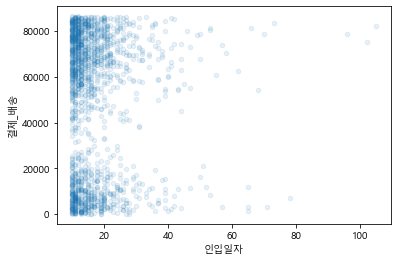

In [88]:
leadtime_df.plot.scatter(y="인입일자", x="결제_배송", alpha=0.1)

<AxesSubplot:xlabel='인입일자', ylabel='결제_개통'>

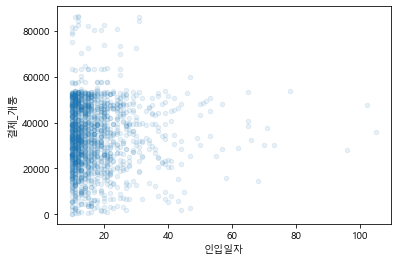

In [89]:
leadtime_df.plot.scatter(y="인입일자", x="결제_개통", alpha=0.1)

<AxesSubplot:xlabel='인입일자', ylabel='배송_개통'>

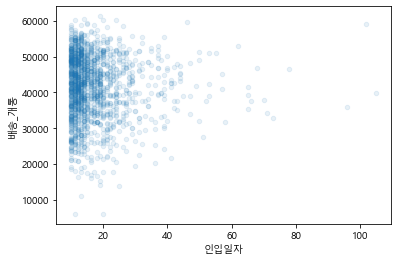

In [90]:
leadtime_df.plot.scatter(y="인입일자", x="배송_개통", alpha=0.1)

## 위 데이터를 보았을 때에는 우선 배송된 뒤에 개통까지 시간이 많이 소요되는 경우와 실제 전화 연결 회수와 관게가 있어 보인다.